In [1]:
import string

import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns

import nltk
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('vader_lexicon')

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.sentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/shrutirao/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('data/904_cleaned_data.csv', index_col=0)

In [3]:
df.describe()

,Could you tell where you are located?,floor,ground-floor,emotion,comfort
count,112,111,112,107,103
unique,4,4,5,102,103
top,A,1st Floor,Group work tables,Relaxed,I feel comfortable but watched
freq,57,62,39,4,1


In [7]:
df = df.rename(columns={"Could you tell where you are located?": "building", "ground-floor": "space-type"})

In [8]:
df

,building,floor,space-type,emotion,comfort
1,C,Ground floor,Group work tables,Chill,I feel comfortable but watched
2,C,Ground floor,Meeting/communal space,"Relaxed, friendly,",NaN
3,A,Ground floor,Meeting/communal space,Relaxed,7/10
4,A,Ground floor,Cafe,Sad,Neutral
5,C,Ground floor,Meeting/communal space,Feels good to see people having fun (for examp...,"The presence of sunlight gives a comfortable, ..."
...,...,...,...,...,...
113,Unsure,1st Floor,Quiet study space,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN
115,A,Ground floor,Cafe,I feel comfortably,NaN
116,NaN,NaN,NaN,NaN,NaN


# Responses Across the Building 904

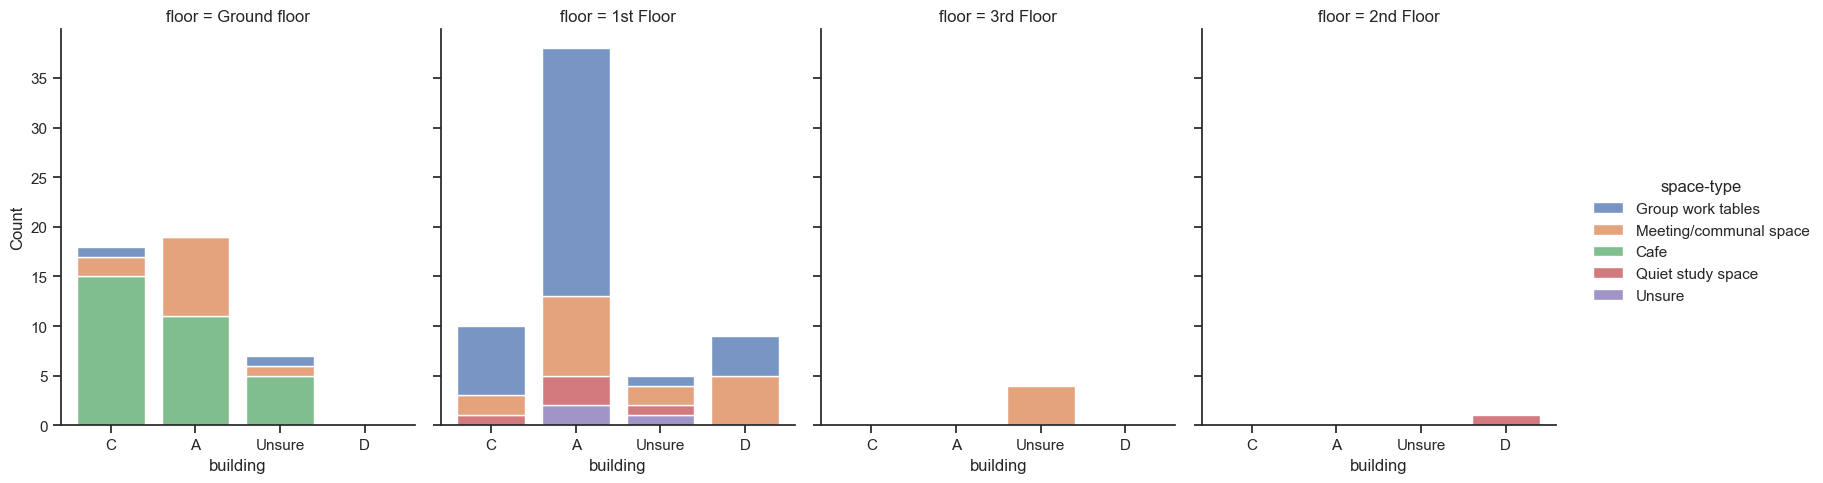

In [87]:
# fig, ax = plt.subplots()
sns.displot(df, x="building", hue="space-type", col="floor", multiple="stack",
            height=5,
            aspect=0.8,
            shrink=.8)
# fig.set_size_inches(8, 5)
plt.savefig('plots/904-floors-responses.jpg', dpi=300, bbox_inches="tight")

# Students Across the Floors

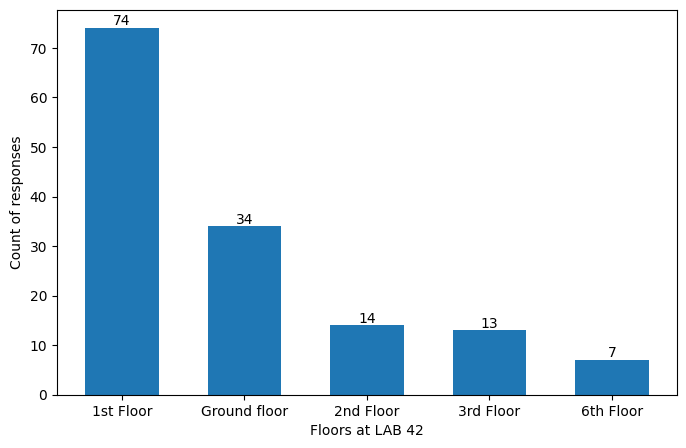

In [6]:
fig, ax = plt.subplots()
data = df.floor.value_counts()
data = pd.DataFrame(data).reset_index().rename(columns={"index": "Floor", "floor": "Count of Responses"})
width = 0.6

p=ax.bar(data.Floor, data["Count of Responses"], width)
ax.bar_label(p, label_type='edge')
plt.ylabel("Count of responses")
plt.xlabel("Floors at LAB 42")
fig.set_size_inches(8, 5)
plt.savefig('plots/floors-responses.jpg', dpi=300, bbox_inches="tight")

# Emotions

In [20]:
df

,building,floor,space-type,emotion,comfort
1,C,Ground floor,Group work tables,Chill,I feel comfortable but watched
2,C,Ground floor,Meeting/communal space,"Relaxed, friendly,",NaN
3,A,Ground floor,Meeting/communal space,Relaxed,7/10
4,A,Ground floor,Cafe,Sad,Neutral
5,C,Ground floor,Meeting/communal space,Feels good to see people having fun (for examp...,"The presence of sunlight gives a comfortable, ..."
...,...,...,...,...,...
113,Unsure,1st Floor,Quiet study space,NaN,NaN
114,NaN,NaN,NaN,NaN,NaN
115,A,Ground floor,Cafe,I feel comfortably,NaN
116,NaN,NaN,NaN,NaN,NaN


In [21]:
df_emo = df.emotion.dropna()
df_emo = df_emo.apply(lambda x: x.replace('’', ''))

### Tokenise

In [22]:
df_emo

1                                                  Chill
2                                    Relaxed, friendly, 
3                                                Relaxed
4                                                    Sad
5      Feels good to see people having fun (for examp...
                             ...                        
106    I would prefer an office because we are at the...
107                                      stressed, bored
110                                      No working vibe
112                                              neutral
115                                   I feel comfortably
Name: emotion, Length: 107, dtype: object

In [23]:
import string

def apply_token(row):
    stop_words = set(stopwords.words("english"))
    words_in_sent = word_tokenize(row)

    filtered_list = []
    
    for word in words_in_sent:
        if word.casefold() not in stop_words:
            filtered_list.append(word)
    
    return filtered_list

In [24]:
df_emo = df_emo.apply(apply_token)

In [25]:
def cleanup(df_emo):
    combo_emo = []
    for row in df_emo:
        combo_emo.append(row)
    
    combo_emo = list(np.concatenate(combo_emo).flat)
    combo_emo = list(filter(lambda token: token not in string.punctuation,
                            combo_emo))
    combo_emo = [x.lower() for x in combo_emo]
    
    return combo_emo

In [26]:
combo_emo_list = cleanup(df_emo)

In [121]:
frequency_distribution = FreqDist(combo_emo_list)
frequency_distribution.most_common(20)

[('relaxed', 22),
 ('happy', 13),
 ('good', 11),
 ('bit', 11),
 ('calm', 10),
 ('stressed', 10),
 ('work', 9),
 ('feel', 9),
 ('fine', 8),
 ('feeling', 8),
 ('comfortable', 7),
 ('open', 7),
 ('space', 7),
 ('people', 6),
 ('nice', 6),
 ('tired', 6),
 ('distracted', 6),
 ('okay', 5),
 ('also', 5),
 ('little', 5)]

In [38]:
def frequency_distribution(lst, label):
    top_n = FreqDist(lst).most_common(20)
    frequency_distribution = pd.Series(dict(top_n))

    sns.set_theme(style="ticks")
    sns.barplot(y=frequency_distribution.index,
                x=frequency_distribution.values,
                palette = 'hls',
                saturation = 8)
    plt.xlabel("Count of responses")
    plt.ylabel("Most frequently occuring responses")
    plt.gcf().set_size_inches(5,7)
    # plt.xlim(0,20)

    plt.savefig('plots/904-' + label + '-freq-dist.jpg',
            dpi=300, bbox_inches='tight')

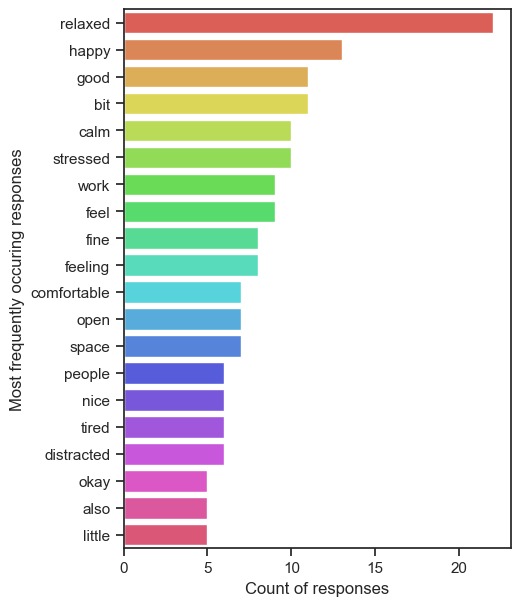

In [30]:
frequency_distribution(combo_emo_list, 'emo')

calm (19), bit (6), nice (5), feel (4), quiet (4), neutral (4), relaxed (4), focused (4), noisy (3), cold (3), stressed (3), happy (3), motivated (3), peaceful (3), tired (3), good (3), study (3), building (3)

Interesting to note that words associated with emotion questions also included some words about comfort such as `cold` and `noisy`. Overall, we see that words associated with emotions are a mix of emotions, moods, sentiments, that are also typically associated with learning (`stressed`, `focused`, `motivated`)

### Lemmatisation

In [31]:
def lemmatiser(labels):
    lemmatizer = WordNetLemmatizer()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in labels]
    return lemmatized_words

def check_collocations(lst):
    return nltk.Text(lst).collocations()
    
def find_collocations(df_emo):
    lem_emo = df_emo.apply(lemmatiser)
    combined_emos = list(np.concatenate(lem_emo.to_list()).flat)
    return check_collocations(combined_emos)

In [32]:
find_collocations(df_emo)

Little cold; Slightly stressed; study space; Good vibe; place work;
bit tired; Relaxed Relaxed


study calm were the most frequently occuring pair of words (collocations) in the list of emotions.

# Comfort

In [33]:
df_comfort = df.comfort.dropna()
df_comfort = df_comfort.apply(lambda x: x.replace('’', ''))

### Tokenise

In [34]:
df_comfort = df_comfort.apply(apply_token)
combo_comfort_list = cleanup(df_comfort)

In [35]:
combo_comfort_list = [word for word in combo_comfort_list if word != "'s"]

In [36]:
frequency_distribution = FreqDist(combo_comfort_list)
frequency_distribution.most_common(20)

[('comfortable', 46),
 ('noise', 35),
 ('bit', 26),
 ('light', 25),
 ('good', 24),
 ('temperature', 23),
 ('quite', 18),
 ('air', 17),
 ('feel', 16),
 ('nice', 15),
 ('cold', 15),
 ('fine', 14),
 ('quality', 13),
 ('noisy', 12),
 ('lot', 12),
 ('little', 9),
 ('chairs', 9),
 ('pretty', 9),
 ('like', 8),
 ('loud', 7)]

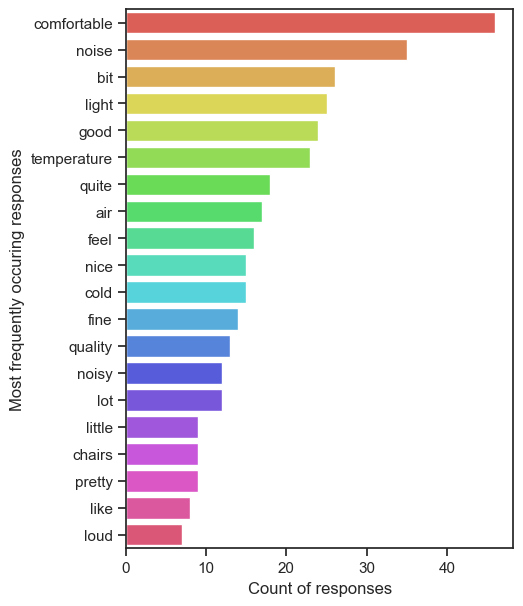

In [39]:
frequency_distribution(combo_comfort_list, 'comfort')

'comfortable' (23), 'light'(12), 'cold' (10), 'good' (10), 'noise' (9), 'temperature' (8), 'air' (8), 'nice' (8), 'room' (7), ('pretty', 7), ('space', 5), ('quality', 5), ('window', 5), ('fine', 5), ('like', 5), ('noisy', 5), ('little', 5), ('well', 4), ('lighting', 4), ('warm', 4), ('lot', 4), ('make', 4), ('feel', 4), ('blinds', 4), ('dark', 4), ('natural', 4), ('ok', 4), ('perfect', 3)

Most focus on light and temperature followed by noise. People also noted overall space and comfort as a whole. 

### Lemmatisation

In [40]:
find_collocations(df_comfort)

air quality; could use; enough light; quite comfortable; background
noise; like background; bit noisy; Good temp; n't mind; Air quality;
natural light; lot echoing; dont mind; much noise; noise level; bit
warm; Quite comfortable; quality fine; feel comfortable; comfortable
Comfortable


Air quality was the most ferquently occuring word.

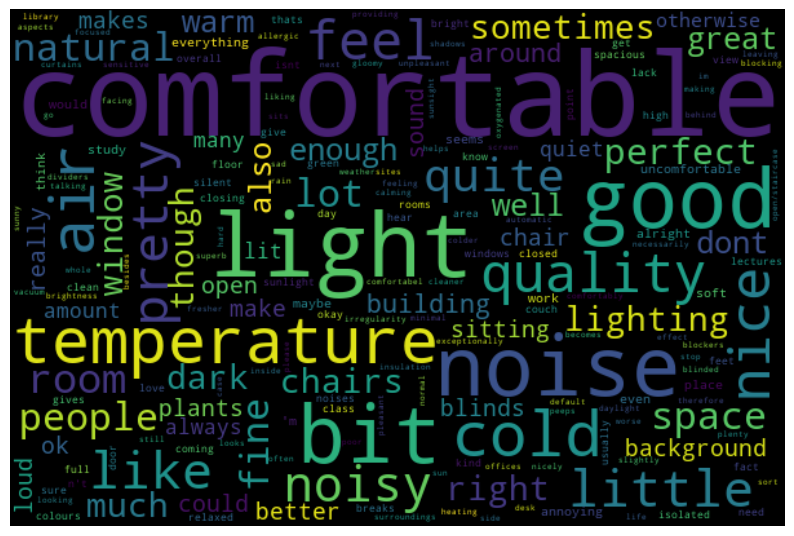

In [51]:
from collections import Counter
combo_comfort_cloud=Counter(combo_comfort_list)

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate_from_frequencies(combo_comfort_cloud)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# Sentiment Analysis

In [115]:
def sentiment_analysis(df, label):
    analyzer = SentimentIntensityAnalyzer()
    df[label + '-polarity'] = df[label].apply(lambda x: analyzer.polarity_scores(str(x)))
    df = pd.concat([df, df[label + '-polarity'].apply(pd.Series)], axis=1)
    df[label + '-sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

    print("Most positive emotion statement: ", df.loc[df['compound'].idxmax()].values)
    print("\n")
    print("Most negative emotion statement: ", df.loc[df['compound'].idxmin()].values)
    
    return df 

In [108]:
def plot_sentiment_analysis(df, label):
    sns.countplot(y=label+'-sentiment', 
                  data=df,
                  palette=['#b2d8d8',"#008080", '#db3d13'])
    plt.ylabel("Sentiment for " + label + " Text")
    plt.xlabel("Count")
    # plt.xlim(0,45)
    plt.savefig('plots/904-' + label + '-sentiment-count.jpg',
                dpi=300, bbox_inches='tight')
    
    plt.clf()
    
    sns.boxplot(x='floor', y='compound', data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/904-' + label + '-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')

In [116]:
df_sent_emo = sentiment_analysis(df, 'emotion')

Most positive emotion statement:  ['A' '1st Floor' 'Quiet study space'
 "I am enjoying the sunlight shining in through the windows of the cafeteria. This makes me happy. I feel focused because this is a relatively quiet working area, also I don't feel unconfortable because it's not too quiet."
 'I enjoy the temperature and air quality. I feel good in the natural sunlight. The noise level is good for focusing.'
 {'neg': 0.0, 'neu': 0.762, 'pos': 0.238, 'compound': 0.8658}
 {'neg': 0.0, 'neu': 0.566, 'pos': 0.434, 'compound': 0.8885} 0.0 0.762
 0.238 0.8658 'positive']


Most negative emotion statement:  ['C' '1st Floor' 'Group work tables' 'stressed, bored'
 'temperature okay, noise okay (although cafeteria is a little bit noisy), air quality fine'
 {'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound': -0.5423}
 {'neg': 0.0, 'neu': 0.641, 'pos': 0.359, 'compound': 0.5574} 1.0 0.0 0.0
 -0.5423 'negative']


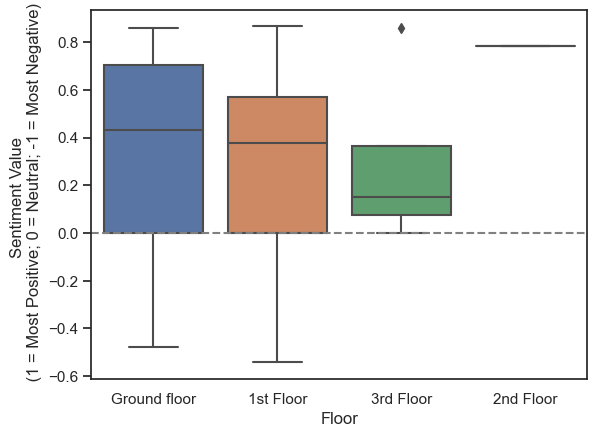

In [46]:
plot_sentiment_analysis(df_sent_emo, 'emotion')

### Emotion: `relaxed`

In [117]:
df_sent_emo[['floor','emotion', 'emotion-sentiment']][df_sent_emo['emotion'].str.contains("relaxed")==True]

,floor,emotion,emotion-sentiment
20,1st Floor,"Little cold, sort of relaxed",positive
38,1st Floor,Curious and relaxed,positive
50,1st Floor,"Bit distracted, relaxed, out in the open",positive
65,1st Floor,I feel relaxed. I’m here to do a bit of studyi...,positive
87,Ground floor,"concentrated, relaxed",positive
88,Ground floor,Nice and relaxed,positive
95,Ground floor,"Fine, relaxed,",positive
104,Ground floor,I feel motivated and also relaxed.,positive


In [120]:
for row in df_sent_emo['emotion'][df_sent_emo['emotion'].str.contains("calm")==True]:
    print(row)

Good, calm
Bright, open, happy, calm
Relaxt, calm
Open and calm 
Feeling anxious and stressed but the space is nice and helps to be more calm


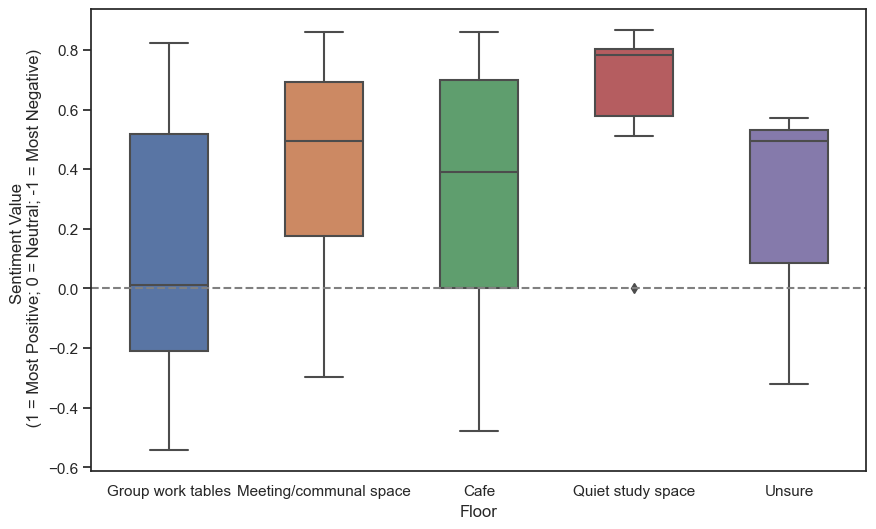

In [110]:
def plot_sentiment_analysis_spaces(df, label):
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/904-' + label + '-space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    
plot_sentiment_analysis_spaces(df_sent_emo, "emotion")

## Comfort:

In [47]:
df_sent_comfort = sentiment_analysis(df, 'comfort')

Most positive emotion statement:  ['A' '1st Floor' 'Group work tables' 'concentrated'
 "pretty comfortabel, but the seats could use some pillows, square tables would be best. it is very light in the space, which is nice, but it also reminds me a bit of a hospital, not very 'gezellig'. temperature is also good; not too hot and not too cold, nice study temperature. "
 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
 {'neg': 0.0, 'neu': 0.697, 'pos': 0.303, 'compound': 0.9645} 0.0 0.697
 0.303 0.9645 'positive']


Most negative emotion statement:  ['D' '1st Floor' 'Meeting/communal space' 'Relaxed'
 'I’m mad I the milk is empty'
 {'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4939}
 {'neg': 0.556, 'neu': 0.444, 'pos': 0.0, 'compound': -0.6124} 0.556 0.444
 0.0 -0.6124 'negative']


In [103]:
def plot_sentiment_analysis_spaces(df, label):
    f = plt.figure(figsize=(10, 6))
    sns.boxplot(x='space-type', y='compound', width=0.5,
 data=df)
    plt.xlabel("Floor")
    plt.ylabel("Sentiment Value \n (1 = Most Positive; 0 = Neutral; -1 = Most Negative)")
    plt.tick_params(bottom=False)
    plt.axhline(0, ls='--', c = 'grey')
    plt.savefig('plots/904-' + label + 'space-wise-sentiment-distribution.jpg',
                dpi=300, bbox_inches='tight')
    
plot_sentiment_analysis_spaces(df_sent_comfort, "comfort")

In [77]:
df_sent_comfort[df_sent_comfort['comfort'].str.contains("loud")==True]


,building,floor,space-type,emotion,comfort,emotion-polarity,comfort-polarity,neg,neu,pos,compound,comfort-sentiment
10,A,1st Floor,Group work tables,Comfortable and at ease mostly. It's a nice pl...,The noise level is okay for working in a group...,"{'neg': 0.0, 'neu': 0.449, 'pos': 0.551, 'comp...","{'neg': 0.1, 'neu': 0.857, 'pos': 0.043, 'comp...",0.1,0.857,0.043,-0.4497,negative
33,Unsure,Ground floor,Cafe,I would describe my feelings as laid back and ...,The cafe was because of the lunch quite loud w...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.907, 'pos': 0.093, 'comp...",0.0,0.907,0.093,0.5106,positive
46,A,1st Floor,Group work tables,"I’m studying with friends, feeling fine :)","I’m comfortable here, but it’s a bit too loud ...","{'neg': 0.0, 'neu': 0.242, 'pos': 0.758, 'comp...","{'neg': 0.0, 'neu': 0.823, 'pos': 0.177, 'comp...",0.0,0.823,0.177,0.2846,positive
47,A,1st Floor,Unsure,I feel slightly annoyed by the people talking ...,"Temperature and air are fine, noise is too lou...","{'neg': 0.133, 'neu': 0.867, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...",0.0,0.870,0.130,0.2023,positive
63,A,1st Floor,Group work tables,Productive and happy,There is enough light and the air quality is f...,"{'neg': 0.0, 'neu': 0.351, 'pos': 0.649, 'comp...","{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou...",0.0,0.940,0.060,0.1027,positive
64,Unsure,1st Floor,Unsure,"It’s loud and open, people work quietly while ...","Very much, temperature is good, loud noise due...","{'neg': 0.0, 'neu': 0.833, 'pos': 0.167, 'comp...","{'neg': 0.0, 'neu': 0.812, 'pos': 0.188, 'comp...",0.0,0.812,0.188,0.7003,positive
96,A,Ground floor,Cafe,Chill but focussed,Quite comfortable now but occasionally loud an...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 0.753, 'pos': 0.247, 'comp...",0.0,0.753,0.247,0.3174,positive


In [73]:
for row in df_sent_comfort['comfort'][df_sent_comfort['comfort'].str.contains("comfortable")==True]:
    print(row, "\n")

I feel comfortable but watched 

The presence of sunlight gives a comfortable, alive feeling 

Temperature and light is good. A little noisy but it is in the central hall so that's to be expected. The wooden benches are not comfortable! 

The noise level is okay for working in a group, but if you wanted to study solo it would be too loud. The chairs are uncomfortable and could use a cushion or something.  

i’m feeling quite comfortable although the white sheets could use some nice soft seating 

Quite comfortable! There is some noise but I don't mind it personally at this moment. Theres some nice light coming from outside. The temperature is good.  

lot of noise, so a bit uncomfortable  

I'm very comfortable. Temperature is fine, I like the background noise of people chatting here, the lighting is okay, air quality is normal, chairs are comfortable  

I feel very comfortable, I don’t feel ant specific emotion, so also quite neutral, again. 

The temperature and light are comfortable